In [1]:
from fastai.vision.all import *

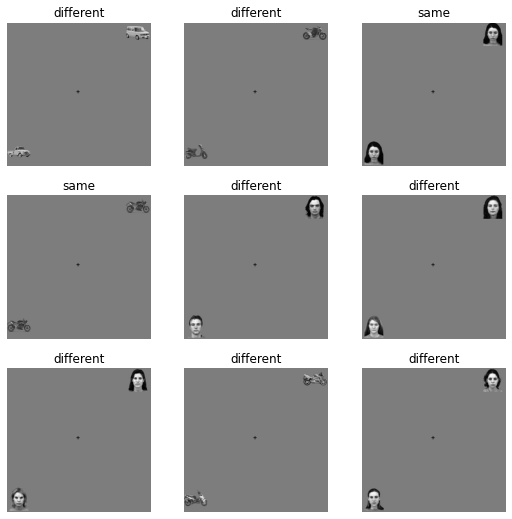

In [2]:
same_diff_dls = ImageDataLoaders.from_folder("../samediff", valid_pct=0.2)
same_diff_dls.show_batch()

In [3]:
def cornet_z_block(in_channels, out_channels, kernel_size=3, stride=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                  stride=stride, padding=kernel_size // 2),
        nn.ReLU(inplace=True), # TODO: Find out what this does
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1), # Magic Numbers!
        Identity()
    )

cornet_z = nn.Sequential(
    cornet_z_block(3, 64, kernel_size=7, stride=2),
    cornet_z_block(64, 128),
    cornet_z_block(128, 256),
    cornet_z_block(256, 512),
    nn.Sequential(
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        nn.Linear(512, 1000),
        Identity()
    )
)

loaded = Learner(same_diff_dls, cornet_z, metrics=accuracy, splitter=default_split)
loaded.load('/imagenet/ILSVRC2012/models/cornet_z_imagenet_greyscale')

/anaconda/envs/fastai2/lib/python3.7/site-packages/fastai/learner.py:55: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


In [13]:
loaded.model[-1][2]= nn.Linear(in_features=512, out_features=2, bias=True)
loaded.freeze_to(-1)
loaded.summary()

Sequential (Input shape: 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9472       False     
ReLU                                                           
MaxPool2d                                                      
Identity                                                       
____________________________________________________________________________
                     64 x 128 x 56 x 56  
Conv2d                                    73856      True      
ReLU                                                           
MaxPool2d                                                      
Identity                                                       
____________________________________________________________________________
                     64 x 256 x 28 x 28  
Conv2d                                    295168     True      
ReLU                                               

In [14]:
loaded.fit_one_cycle(10)


epoch,train_loss,valid_loss,accuracy,time
0,0.963930,0.909508,0.176471,00:01
1,0.872037,0.649956,0.823529,00:01
2,0.758687,0.471894,0.823529,00:01
3,0.682494,0.466871,0.823529,00:01
4,0.635575,0.466322,0.823529,00:01
5,0.601935,0.469781,0.823529,00:01
6,0.581187,0.469048,0.823529,00:01
7,0.568129,0.468973,0.823529,00:01
8,0.556177,0.468827,0.823529,00:01
9,0.548636,0.468844,0.823529,00:01


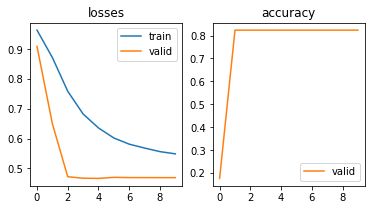

In [15]:
recorder = loaded.recorder
metrics =  np.stack(recorder.values)
names = recorder.metric_names[1:-1]
n = len(names) -1
fig, axs = subplots(1, 2)
axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]

for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')

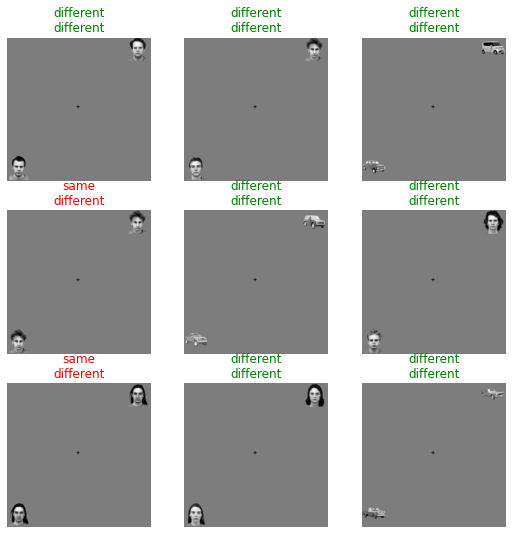

In [8]:
loaded.show_results()

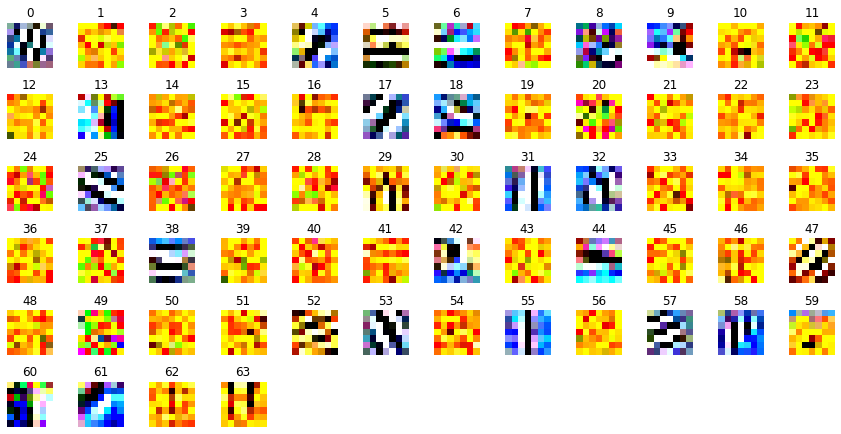

In [16]:
weights = loaded.model[0][0].weight.data.cpu()


def plot_filters_multi_channel(t):
    
    #get the number of kernels
    num_kernels = t.shape[0]    
    
    #define number of columns for subplots
    num_cols = 12
    #rows = num of kernels
    num_rows = num_kernels
    
    #set the figure size
    fig = plt.figure(figsize=(num_cols,num_rows))
    
    #looping through all the kernels
    for i in range(t.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        
        #for each kernel, we convert the tensor to numpy 
        npimg = np.array(t[i].numpy(), np.float32)
        #standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
    plt.savefig('myimage.png', dpi=100)    
    plt.tight_layout()
    plt.show()
    
plot_filters_multi_channel(weights)